## Importing Dependencies

In [3]:
import numpy as np

In [2]:
import pandas as pd

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

In [7]:
def read_xom_oil_nasdaq_data():
    def readFile(filename):
        data = pd.read_csv(filename,sep=',',usecols=[0,5],names=['Date','Price'],header=0)
        data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
        data = data.sort_values(['Date'],ascending=True)
        returns = data[[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64','int64']]].pct_change()
        return np.array(returns['Price'])[1:]
    nasdaqData = readFile('./data/NASDAQ.csv')
    oilData = readFile('./data/USO.csv')
    xomData = readFile('./data/XOM.csv')
    return (nasdaqData,oilData,xomData)

In [8]:
nasdaqData, oilData, xomData = read_xom_oil_nasdaq_data()

In [13]:
len(nasdaqData)
len(oilData)
len(xomData)

126

## Scikit Learn Baseline 

In [14]:
from sklearn import datasets, linear_model

In [16]:
regressor = linear_model.LinearRegression()

In [17]:
combined = np.vstack((nasdaqData, oilData)).T

In [19]:
regressor.fit(combined,xomData)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
regressor.coef_

array([0.25118806, 0.14642728])

In [22]:
regressor.intercept_

0.0032059862138337147

In [60]:
predicted = regressor.predict(combined)

In [61]:
true = xomData

In [63]:
sum_of_square_residuals = np.sum(np.square(true - predicted))

In [65]:
sum_of_square_total = np.sum(np.square(true - np.average(predicted)))

In [66]:
r_squarred = 1 - np.divide(sum_of_square_residuals,sum_of_square_total)

In [44]:
# R-Squared = 1 - (Explained Variation / Total Variation)

In [67]:
print("The R-Squarred Error is: {}".format(r_squarred))

The R-Squarred Error is: 0.22776256213951973


## Tensorflow Implementation

In [69]:
import tensorflow as tf

In [70]:
nasdaq_w = tf.Variable(tf.zeros([1,1]),name='nasdaq_w',dtype=tf.float32)
oil_w = tf.Variable(tf.zeros([1,1]),name='oil_w',dtype=tf.float32)
b = tf.Variable(tf.zeros([1]),name='b',dtype=tf.float32)

In [71]:
nasdaq_x = tf.placeholder(dtype=tf.float32,shape=[None,1],name='nasdaq_x')
oil_x = tf.placeholder(dtype=tf.float32,shape=[None,1],name='oil_x')

In [73]:
y_ = tf.placeholder(dtype=tf.float32,shape=[None,1],name='y_')

In [74]:
nasdaq_wx = tf.matmul(nasdaq_x,nasdaq_w)
oil_wx = tf.matmul(oil_x,oil_w)
y = nasdaq_wx + oil_wx + b

In [75]:
loss = tf.reduce_sum(tf.square(y_ - y))

In [76]:
optimizer = tf.train.FtrlOptimizer(0.1)

In [77]:
train = optimizer.minimize(loss)

In [80]:
all_x_nasdaq = nasdaqData.reshape(-1,1)
all_x_oil = oilData.reshape(-1,1)
all_ys = xomData.reshape(-1,1)

In [81]:
dataset_size = len(oilData)

In [84]:
def trainWithMultiplePointsPerEpoch(steps, train_step, batch_size):
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for i in range(steps):
            if dataset_size==batch_size:
                batch_start_idx = 0
            elif dataset_size<batch_size:
                raise ValueError("Dataset size %d must be greater than Batch size %d"%(dataset_size,batch_size))
            else:
                batch_start_idx = (i * batch_size) % (dataset_size)
            batch_end_idx = batch_start_idx + batch_size
            
            #Acess the x and y values in batches
            batch_x_nasdaq = all_x_nasdaq[batch_start_idx:batch_end_idx]
            batch_x_oil = all_x_oil[batch_start_idx:batch_end_idx]
            batch_ys = all_ys[batch_start_idx:batch_end_idx]
            feed_dict = {nasdaq_x:batch_x_nasdaq,oil_x:batch_x_oil,y_:batch_ys}
            sess.run(train_step,feed_dict=feed_dict)
            if (i)%100==0:
                print("After {} iteration.".format(i))
                print("nasdaq_w: {}".format(sess.run(nasdaq_w)))
                print("oil_w: {}".format(sess.run(oil_w)))
                print("b: {}".format(sess.run(b)))
        trained_nasdaq_w = sess.run(nasdaq_w)
        trained_oil_w = sess.run(oil_w)
        trained_b = sess.run(b)
    return trained_nasdaq_w, trained_oil_w, trained_b

In [86]:
trained_nasdaq_w,trained_oil_w,trained_b = trainWithMultiplePointsPerEpoch(20000,train,100)

After 0 iteration.
nasdaq_w: [[0.05722181]]
oil_w: [[0.07481174]]
b: [0.09434591]
After 100 iteration.
nasdaq_w: [[0.27722105]]
oil_w: [[0.17994392]]
b: [0.00706963]
After 200 iteration.
nasdaq_w: [[0.26882294]]
oil_w: [[0.16737598]]
b: [0.00158484]
After 300 iteration.
nasdaq_w: [[0.27000704]]
oil_w: [[0.161919]]
b: [0.00163913]
After 400 iteration.
nasdaq_w: [[0.2703731]]
oil_w: [[0.16633706]]
b: [0.00345861]
After 500 iteration.
nasdaq_w: [[0.2692369]]
oil_w: [[0.16622676]]
b: [0.00308334]
After 600 iteration.
nasdaq_w: [[0.27609074]]
oil_w: [[0.17504224]]
b: [-0.00084845]
After 700 iteration.
nasdaq_w: [[0.27482283]]
oil_w: [[0.17388757]]
b: [0.00181568]
After 800 iteration.
nasdaq_w: [[0.26890606]]
oil_w: [[0.16681224]]
b: [0.00010719]
After 900 iteration.
nasdaq_w: [[0.27600935]]
oil_w: [[0.169997]]
b: [0.00553047]
After 1000 iteration.
nasdaq_w: [[0.2691207]]
oil_w: [[0.16634713]]
b: [0.00195293]
After 1100 iteration.
nasdaq_w: [[0.27209505]]
oil_w: [[0.16701373]]
b: [0.00195156

nasdaq_w: [[0.27204183]]
oil_w: [[0.16935536]]
b: [0.00271682]
After 9800 iteration.
nasdaq_w: [[0.27351198]]
oil_w: [[0.17158836]]
b: [0.00190542]
After 9900 iteration.
nasdaq_w: [[0.27296284]]
oil_w: [[0.16946381]]
b: [0.00440451]
After 10000 iteration.
nasdaq_w: [[0.27158162]]
oil_w: [[0.1690469]]
b: [0.00308944]
After 10100 iteration.
nasdaq_w: [[0.27207404]]
oil_w: [[0.16874537]]
b: [0.00270091]
After 10200 iteration.
nasdaq_w: [[0.27303538]]
oil_w: [[0.17040631]]
b: [0.00333009]
After 10300 iteration.
nasdaq_w: [[0.27228916]]
oil_w: [[0.16935144]]
b: [0.00276766]
After 10400 iteration.
nasdaq_w: [[0.2732947]]
oil_w: [[0.17055264]]
b: [0.00181308]
After 10500 iteration.
nasdaq_w: [[0.27383277]]
oil_w: [[0.1705676]]
b: [0.00472015]
After 10600 iteration.
nasdaq_w: [[0.2710885]]
oil_w: [[0.1688562]]
b: [0.00243338]
After 10700 iteration.
nasdaq_w: [[0.27206102]]
oil_w: [[0.16783103]]
b: [0.00217398]
After 10800 iteration.
nasdaq_w: [[0.2722972]]
oil_w: [[0.16951665]]
b: [0.00319415]

After 19400 iteration.
nasdaq_w: [[0.27168497]]
oil_w: [[0.16916306]]
b: [0.00279248]
After 19500 iteration.
nasdaq_w: [[0.27339435]]
oil_w: [[0.17098096]]
b: [0.00159947]
After 19600 iteration.
nasdaq_w: [[0.27295685]]
oil_w: [[0.1707469]]
b: [0.00191843]
After 19700 iteration.
nasdaq_w: [[0.2719213]]
oil_w: [[0.1693658]]
b: [0.00345463]
After 19800 iteration.
nasdaq_w: [[0.2733907]]
oil_w: [[0.16996899]]
b: [0.00381092]
After 19900 iteration.
nasdaq_w: [[0.27147722]]
oil_w: [[0.16910078]]
b: [0.00229567]


In [87]:
trained_b

array([0.00322051], dtype=float32)

In [88]:
print("trained_nasdaq_w: {}, trained_oil_w: {}".format(trained_nasdaq_w,trained_oil_w))

trained_nasdaq_w: [[0.27328447]], trained_oil_w: [[0.17061117]]


In [89]:
a = trained_nasdaq_w*nasdaqData + trained_oil_w*oilData + trained_b

In [92]:
a = a.squeeze()

In [94]:
true = xomData
predicted = a
sum_of_square_residuals = np.sum(np.square(true - predicted))
sum_of_square_total = np.sum(np.square(true - np.average(predicted)))

In [95]:
r_squarred = 1 - np.divide(sum_of_square_residuals,sum_of_square_total)

In [97]:
print("The R-Squarred Error is: {}".format(r_squarred))

The R-Squarred Error is: 0.22384929201607706


### Better Explanation of Data

In [4]:
googFile = 'data/GOOG.csv'
spFile = 'data/SP_500.csv'

In [7]:
df1 = pd.read_csv(googFile,sep=',',usecols=[0,5],names=['Date','Goog'],header=0)

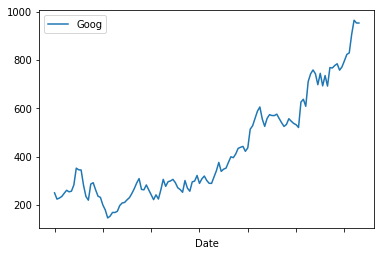

In [14]:
df1.plot(x='Date',y='Goog')
plt.show()

In [15]:
df2 = pd.read_csv(spFile,sep=',',usecols=[0,5],names=['Date','SP500'],header=0)

In [16]:
df2.head()

,Date,SP500
0,2007-01-01,1438.239990
1,2007-02-01,1406.819946
2,2007-03-01,1420.859985
3,2007-04-01,1482.369995
4,2007-05-01,1530.619995


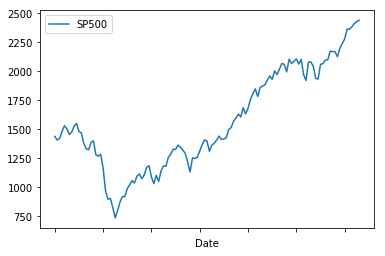

In [17]:
df2.plot(x='Date',y='SP500')

In [18]:
df1['SP500'] = df2['SP500']

In [19]:
df1.keys()

Index(['Date', 'Goog', 'SP500'], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B38C3C5C0>],
      dtype=object)

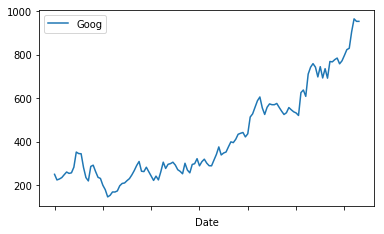

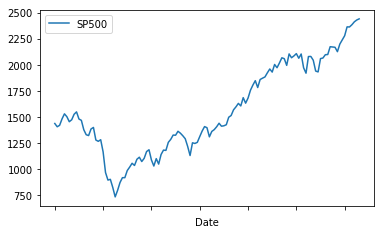

In [22]:
df1.plot(x='Date',y='Goog',subplots=True)
df1.plot(x='Date',y='SP500',subplots=True)

In [23]:
df1.head()

,Date,Goog,SP500
0,2007-01-01,249.813644,1438.239990
1,2007-02-01,223.885818,1406.819946
2,2007-03-01,228.224564,1420.859985
3,2007-04-01,234.809875,1482.369995
4,2007-05-01,248.025345,1530.619995


In [25]:
df1['Date'] = pd.to_datetime(df1['Date'],format='%Y-%m-%d')

In [26]:
df1.head()

,Date,Goog,SP500
0,2007-01-01,249.813644,1438.239990
1,2007-02-01,223.885818,1406.819946
2,2007-03-01,228.224564,1420.859985
3,2007-04-01,234.809875,1482.369995
4,2007-05-01,248.025345,1530.619995


In [28]:
df1 = df1.sort_values('Date')

In [35]:
returns = df1[[key for key in dict(df1.dtypes) if dict(df1.dtypes)[key] in ['float64','int64']]].pct_change()

In [37]:
xData = np.array(df1['SP500'][1:])

In [39]:
yData = np.array(df1['Goog'][1:])